<a href="https://colab.research.google.com/github/DasBlaueWunder/Homeworx/blob/main/Homework9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import signal
import numpy as np

# LSTM


In [ ]:
class Model(object):
	def __init__(self, input_length):
		# Initialize the weights
		self.neurons = 10
		self.weight_sd = 0.1 # initial standard deviation of weights
		self.output_length = input_length - 2


    # forget gate
		self.W_f = tf.Variable(np.random.randn(self.neurons, self.neurons + input_length) * self.weight_sd)
		self.b_f = tf.Variable(np.ones((self.neurons, 1))) # thanks to Jozefowicz et al.

    # input gate
		self.W_i = tf.Variable(np.random.randn(self.neurons, self.neurons + input_length) * self.weight_sd)
		self.b_i = tf.Variable(np.zeros((self.neurons, 1)))

    # Cell-state Candidates
		self.W_C = tf.Variable(np.random.randn(self.neurons, self.neurons + input_length) * self.weight_sd)
		self.b_C = tf.Variable(np.zeros((self.neurons, 1)))

    # Output Gate
		self.W_o = tf.Variable(np.random.randn(self.neurons, self.neurons + input_length) * self.weight_sd)
		self.b_o = tf.Variable(np.zeros((self.neurons, 1)))

		# final layer for output
		self.W_v = tf.Variable(np.random.randn(self.output_length, self.neurons) * self.weight_sd)
		self.b_v = tf.Variable(np.zeros((self.output_length, 1)))
    
    # for recursion
		self.forget()
  
    # set trainable variables (all but {h,C}_prev)
		self.trainable_variables = [self.W_f, self.b_f, self.W_i, self.b_i, self.W_C, self.b_C, self.W_o, self.b_o, self.W_v, self.b_v]

	def forget(self):
		self.h_prev = np.zeros((self.neurons, 1))
		self.C_prev = np.zeros((self.neurons, 1))

	def __call__(self, inputs, T_steps = 50):
		outputs = []
		for time_step in range(T_steps):
			x = inputs[time_step,:]
			x = tf.expand_dims(x,axis=1)

			z = tf.concat([self.h_prev,x],axis=0)

      # forget gate
			f = tf.matmul(self.W_f, z) + self.b_f
			f = tf.sigmoid(f)

      # input gate
			i = tf.matmul(self.W_i, z) + self.b_i
			i = tf.sigmoid(i)

      # Output Gate
			o = tf.matmul(self.W_o, z) + self.b_o
			o = tf.sigmoid(o)

      # Cell-state Candidates
			C_bar = tf.matmul(self.W_C, z) + self.b_C
			C_bar = tf.tanh(C_bar)
   
      # Updating the cell state (numpy style broadcasting)
			C = (f * self.C_prev) + (i * C_bar)

      # new hidden state
			h = o * tf.tanh(C)

      # Dense network for output
			v = tf.matmul(self.W_v, h) + self.b_v
			v = tf.sigmoid(v)

			y = tf.math.softmax(v, axis=0)

			self.h_prev = h
			self.C_prev = C

			outputs.append(y)
		outputs = tf.squeeze(tf.stack(outputs,axis=1))
		return outputs

### Defining the task


In [ ]:
import random

class Tasker():
    
    def __init__(self, length=100, time_steps=1):
        self.length = length
        self.time_steps = time_steps
     
    def calculate_target(self, sample):

        shape_target = list(sample.shape)
        shape_target[1] = shape_target[1] - 2

        target = np.zeros(shape_target)
        for i in range(shape_target[0]):
          # context
          a = sample[i,0]
          b = sample[i,1]

          # decision
          r = 0

          # generate target
          for j in range(shape_target[1]):
            if sample[i,j+2] == a:
              r += 1
            elif sample[i,j+2] == b:
              r -= 1

            if r>0:
              target[i,j]= 1
            elif r<0:
              target[i,j] = -1
            else:
              target[i,j] = 0

        return target   
    def plot_input_target(self, n, length=None, style='seaborn'):
        mpl.style.use(style)
        length = (length or self.length)

        fig, axes = plt.subplots(2, sharex=True)
        
        input, target = self.generate_sample(length=length, time_steps=n)

        for i in range(n):
            axes[0].plot(input[i], alpha=0.7)
            axes[1].plot(target[i], alpha=0.7)
            axes[1].set_xlabel("Time [t]")
            axes[0].set_ylabel("Signal")
            axes[1].set_ylabel("Binary Decision")
        plt.tight_layout()
        plt.show()

    def generate_sample(self, length=None, time_steps=None):
        """
        Function that samples an input target timeseries pair
        @output:
            sample: (time_steps, sample_length)
            target: (time_steps, target_length)
        """
        length = (length or self.length)
        time_steps = (time_steps or self.time_steps)
        shape_sample = (time_steps, length+2)
        shape_target = (time_steps, length)

        # Own part:
        # sample context numbers and sequences, calculate target and concatenate [context, sequence]
        sample = np.zeros(shape=shape_sample)
        for batch in range(time_steps):
          sample[batch,0:2] = random.sample(range(1, 9), 2)
          for i in range(length-2):
            n = random.randint(1,9)
            sample[batch,i+2] = n

        target = self.calculate_target(sample)

        return sample, target
    
        

[[8. 1. 7. 3. 8. 1. 3. 8. 4. 5. 0. 0.]
 [2. 3. 5. 9. 6. 5. 3. 9. 5. 9. 0. 0.]]
[[ 0.  0.  1.  0.  0.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0. -1. -1. -1. -1. -1. -1.]]


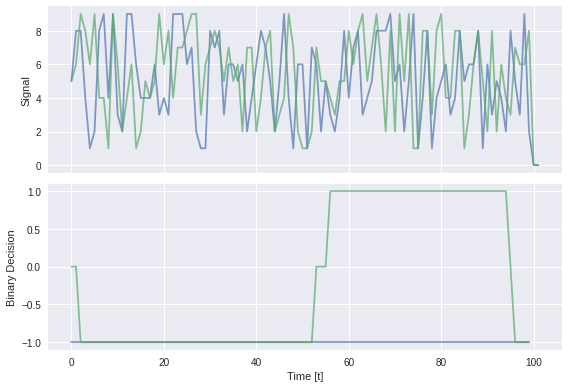

In [ ]:
task = Tasker()
sample, target = task.generate_sample(batch_size = 2, time_steps = 2, length = 10)
# print two sample
print(sample)
print(target)

# visualize two samples
task.plot_input_target(2)

### Training

The training loop will be a bit different from what you are used to as we do not have a fixed dataset nor any training data, as we are always able to generate new unseen data with our task class. Therefore we can compute the accuracy on each sample, as it is always new, and are not in need of any testing steps on seperate datasets.

In [ ]:
def train_step(model, input, target, loss_function, optimizer):
    
    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    # accuracy using a 0.5 threshold
    acc = np.sum(np.abs((target-prediction))<0.5)/(target.shape[0]*target.shape[1])

    return np.mean(loss), acc


In [ ]:
def train(model, task, steps=5000, print_every=500, running_average_factor = 0.95):
    
    optimizer = tf.keras.optimizers.Adam()
    cross_entropy_loss = tf.keras.losses.MSE

    losses = []
    acces = []

    running_average_loss = 0
    running_average_acc = 0
    i=0

    for i in range(steps):
        # generating a new sample in each training step
        model.forget() # forget state before new sample
        samples, targets = task.generate_sample()
        loss, acc = train_step(model, samples, targets, cross_entropy_loss, optimizer)
        
        # compute the running averages of training loss and accuracy
        running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * loss
        running_average_acc = running_average_factor * running_average_acc  + (1 - running_average_factor) * acc
        losses.append(running_average_loss)
        acces.append(running_average_acc)
        
        if i%print_every==0:
            print(f"Training step {i}: average loss is {np.round(losses[-1],2)}, accuracy of {np.round(acces[-1], 2)} %")
        
        if i == steps:
            break
        i+=1
    return losses, acces

In [ ]:
def visualize(losses, acces, name=''):
    plt.figure()
    plt.title(name)
    line1, = plt.plot(losses)
    plt.xlabel("Training steps")
    plt.ylabel("Loss")
    plt.show()
    plt.figure()
    line1, = plt.plot(acces)
    plt.xlabel("Training steps")
    plt.ylabel("Accuracy")
    plt.show()


Training step 0: average loss is 0.04, accuracy of 0.01 %
Training step 500: average loss is 0.78, accuracy of 0.22 %
Training step 1000: average loss is 0.78, accuracy of 0.22 %
Training step 1500: average loss is 0.78, accuracy of 0.22 %
Training step 2000: average loss is 0.79, accuracy of 0.21 %
Training step 2500: average loss is 0.78, accuracy of 0.22 %
Training step 3000: average loss is 0.78, accuracy of 0.22 %
Training step 3500: average loss is 0.78, accuracy of 0.22 %
Training step 4000: average loss is 0.78, accuracy of 0.22 %
Training step 4500: average loss is 0.78, accuracy of 0.22 %


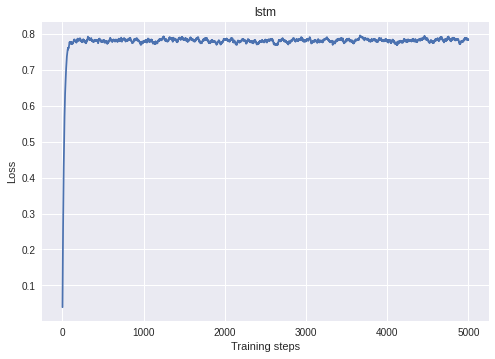

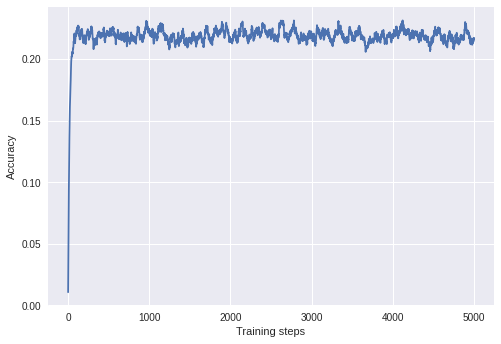

In [ ]:
model = Model(input_length=50+2)
task = Tasker(length=50, time_steps=50)
losses, acces = train(model, task)
visualize(losses, acces, 'lstm')